In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#constants
LANE_WIDTH = 340
cap = cv2.VideoCapture("project_data\project_video.mp4")
# debug = 1

In [2]:
def PerspectiveTransform(src,dst):
    mat = cv2.getPerspectiveTransform(src,dst)
    mat_inv = cv2.getPerspectiveTransform(dst,src)
    return mat,mat_inv

def warpPerspective(img, mat, size):
    return cv2.warpPerspective(img, mat,size, cv2.INTER_LINEAR)

#function for converting the image to hls mode then return s as it is the one we are intrested in studying
def trans2hls(image):
    img_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    (h,l,s) = cv2.split(img_hls)
    return s

In [3]:
#images must have the same dimension
#takes a list of images and produces an image of them concantenated in a 2D array-like shape
#need to take care of colored images 
def debug_mode(images , resize_factor):
    x_dim = int(images[0].shape[1] / resize_factor)
    y_dim = int(images[0].shape[0] / resize_factor)

    if (len(images) % 2 )!= 0:
        images.append(np.zeros_like(images[0]))
    
    for image in images:
        plt.imshow(image , cmap = 'gray')
        plt.figure()
        
    n_h_images = len(images)
    i = 0
    horiz_conc_image = list()
    
    while i < n_h_images:
        images[i] = cv2.resize(images[i], (x_dim , y_dim), interpolation= cv2.INTER_LINEAR)
        images[i + 1] = cv2.resize(images[i+1], (x_dim , y_dim), interpolation= cv2.INTER_LINEAR)
        print(images[i].shape , " " , images[i+1].shape)
        
        horiz_conc_image.append(cv2.hconcat([images[i] , images[i+1]]))
        i += 2
  

        
#     n_v_images = len(horiz_conc_image)
#     i = 1
    debug_image = cv2.vconcat(horiz_conc_image)
#     while i < n_v_images:
#         horiz_conc_image[0] = cv2.vconcat([horiz_conc_image[0] , horiz_conc_image[i]])
#         i += 1
    return debug_image

In [4]:
def detectLane(frame, src_pts, dst_pts, size, kernel_op_size, kernel_cl_size , debug):
    #colors for drawing line
    red = (255 , 0 ,0)
    green = (0 ,255,0)
    
    #bounds init
    left = 0
    bound_bottom_left = (0,0)
    bound_bottom_right = (0,0)
    pipeline = list()
    
    sat = trans2hls(frame)
    pipeline.append(sat)
    
    canny = cv2.Canny(sat,50,150)
    pipeline.append(canny)
    

    #pre-processing the edge extracted image
    #performing opening operation to remove extra noise
    open_canny = cv2.morphologyEx(canny, cv2.MORPH_OPEN,np.ones(kernel_op_size, np.uint8))
    pipeline.append(open_canny)
    
    #performing closing operation to thicken lane lines
    close_canny = cv2.morphologyEx(open_canny, cv2.MORPH_CLOSE,np.ones(kernel_cl_size, np.uint8))
    pipeline.append(close_canny)
    
    #performing perspective transform
    mat, mat_inv = PerspectiveTransform(src_pts,dst_pts)
    bird_view_gray = warpPerspective(close_canny,mat,size)
    bird_view = warpPerspective(frame,mat,size)
    pipeline.append(bird_view)
    #retrans = warpPerspective(bird_view_gray, mat_inv, size)
    
    #detecting lane lines
    lines = cv2.HoughLinesP(bird_view_gray,1, np.pi/180,50,minLineLength=400, maxLineGap=60 )
    
    #line[0] returns x,y reversed where x is horizontal axis and y is the vertical axis
    i=0
    for line in lines:
        x1,y1,x2,y2 = line[0]
        if(x1>350): #in case the second lane line was on the right side
            cv2.line(bird_view,(x1,y1),(x2,y2),red,2)
            if(x1+LANE_WIDTH < 900):
                cv2.line(bird_view,(x1+LANE_WIDTH,y1),(x2+LANE_WIDTH,y2),red,2)
                x3 = x1+LANE_WIDTH
                x4 = x2+LANE_WIDTH
            if(x1-LANE_WIDTH > 300): #in case the second lane line was on the left
                left = 1
                cv2.line(bird_view,(x1-LANE_WIDTH,y1),(x2-LANE_WIDTH,y2),red,2)
                x3 = x1-LANE_WIDTH
                x4 = x2-LANE_WIDTH

            #340 is fixed which represents the lane width
            if(i<=4):
                #getting the boundary of lines to draw the contour(boundary)
    ###### momken a7sen fe deh eny a3mlha b minimum w maximum x1 w x2
                bound_top_left= (x1,y1)
                bound_top_right= (x3,y1)
            
            if(y2 > bound_bottom_left[1]):
            
                bound_bottom_left = (x2,y2)
                if(left == 1):
                    bound_bottom_right = (x2-LANE_WIDTH,y2)
                else:
                    bound_bottom_right = (x2+LANE_WIDTH,y2)
        i=i+1
        
    #drawing the top and bottom boundaries
    cv2.line(bird_view,bound_bottom_left,bound_bottom_right,red,5)
    cv2.line(bird_view,bound_top_left,bound_top_right,red,5)
    
    # drawing the green region representing the lane
    contours = np.array([bound_top_left,bound_top_right,bound_bottom_right, bound_bottom_left])
    cv2.fillPoly(bird_view,pts = [contours],color = green)

    #transforming the view back from bird eye view
    re_gen = warpPerspective(bird_view, mat_inv, size)

    #combning modified frame with original frame
    image = np.zeros_like(frame)
    cv2.addWeighted(frame, 0.5, re_gen, 0.5,0, image)
#     pipeline.append(image)
    if debug == 1:
        return debug_mode(pipeline , resize_factor= 2)
    else:
        return image

In [5]:
#defining points for perspective transform

input_top_left = [580,480]
input_top_right = [820,480]
input_bottom_right = [1200,700]
input_bottom_left = [200,700]
src_points = np.float32([input_bottom_left,input_top_left,input_top_right,input_bottom_right])


(360, 640)   (360, 640)
(360, 640)   (360, 640)
(360, 640, 3)   (360, 640)


error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\core\src\matrix_operations.cpp:68: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'cv::hconcat'


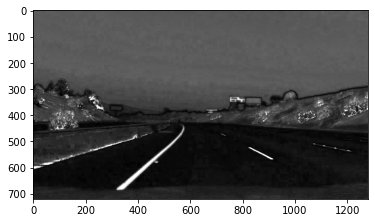

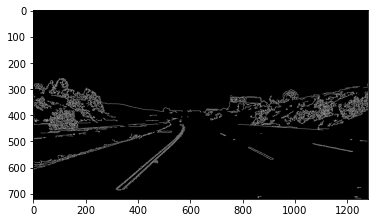

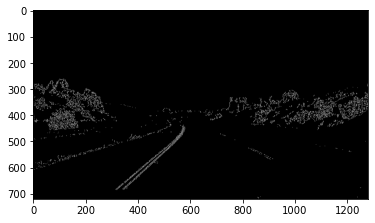

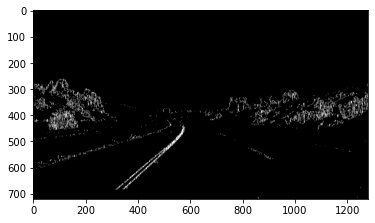

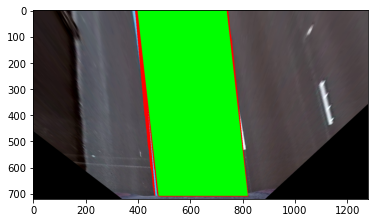

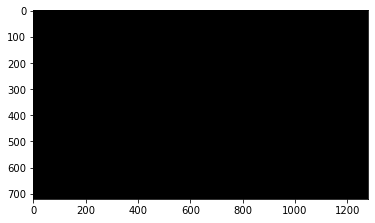

<Figure size 432x288 with 0 Axes>

In [6]:
count = 0
while cap.isOpened():
    ret,frame = cap.read()
    if not ret:
        continue
    #code for modifying video frames
    dst_points = np.float32([[frame.shape[1] // 3,720],[frame.shape[1] // 3,0],[2 *( frame.shape[1] // 3),0],[2 * (frame.shape[1] // 3),720]])
    frame = detectLane(frame, src_points, dst_points, (1280,720),kernel_op_size=2 , kernel_cl_size=7 , debug=1 )
    cv2.imshow('window-name', frame)
    
    count = count + 1
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()